# Базові алгоритми машинного навчання: кластеризація 

Кластеризація - це метод машинного навчання без вчителя, який включає кластеризацію (групування) заданих нерозмічених даних. Алгоритм кластеризації передбачає, що точки даних, які знаходяться в одному кластері, повинні мати схожі властивості, а точки даних у різних кластерах повинні мати властивості, що сильно відрізняються.  
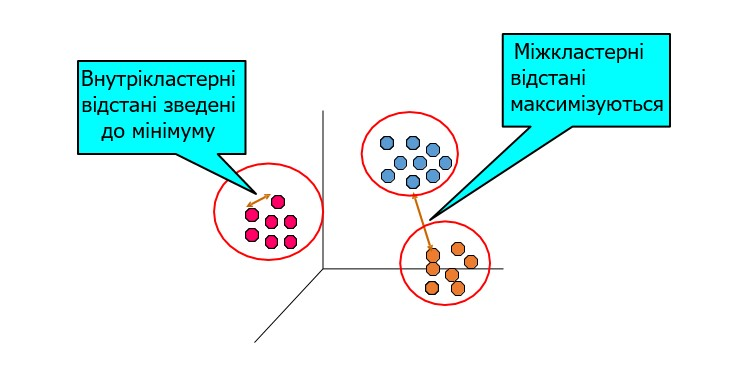  

Кластер: набір об'єктів, подібних (або пов'язаних) один з одним у межах однієї групи, несхожих (або не пов'язаних) з об'єктами в інших групах.

Кластерний аналіз (або кластеризація, сегментація даних,…): пошук подібності між даними відповідно до характеристик, знайдених у даних, і групування подібних об’єктів даних у кластери.

#### Застосування кластерного аналізу  
1. Сегментація ринку та клієнтів  
2. Сегментація зображень  
3. Виявлення аномалій  
5. Кластеризація текстів та мов  

### Практична реалізація кластерного аналізу із використанням методу k-середніх  
Метод K-середніх — це популярний алгоритм кластеризації, який використовується для поділу даних на групи (кластери) на основі схожості між точками. Він працює наступним чином:

- Вибір кількості кластерів (K): Спочатку ви визначаєте, на скільки кластерів потрібно розділити дані.  
- Ініціалізація центроїдів: Алгоритм випадковим чином обирає K точок, які будуть початковими центрами (центроїдами) кластерів. **Центроїд — це точка, яка представляє центр кластера. У контексті кластеризації, зокрема методу K-середніх, центроїд є середнім значенням усіх точок, що належать до певного кластера.**
- Призначення точок до кластерів: Кожна точка даних призначається до найближчого центроїда на основі відстані (зазвичай евклідової).
- Оновлення центроїдів: Після призначення точок до кластерів обчислюється новий центроїд для кожного кластера як середнє значення всіх точок у цьому кластері.
- Повторення: Кроки 3 і 4 повторюються, доки центроїди перестануть змінюватися або не досягнуто максимальну кількість ітерацій.

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('customers_mall.csv')
data.head()

,Annual Income (k$),Spending Score (1-100),Discount Tier,Satisfaction Level
0,15,39,Bronze,Satisfied
1,15,81,Silver,Satisfied
2,16,6,No,Satisfied
3,16,77,Silver,Neutral
4,17,40,Bronze,Very Satisfied


### Опис датафрейму 
На основі наведеної в датафреймі інформації про клієнтів супермаркету, а саме:
- **Annual Income:** річний дохід клієнтів у тис. дол. США  
- **Spending Score (1-100):** оцінка витрат від 1-100. 100 означає, що клієнт є активним покупцем
- **Discount Tier** категоріальний стовпчик, який вказує на рівень знижки, доступний для клієнта (No, Bronze, Silver, Gold)  
- **Satisfaction Level** категоріальний стовпчик, що відображає рівень задоволеності клієнта (Very Dissatisfied, Dissatisfied, Neutral, Satisfied, 
Very Satisfied.
  
Необхідно сегментувати клієнтів супермаркету для кращого розуміння їхніх потреб, вподобань та поведінки. Це дозволить виділити різні групи клієнтів на основі їхнього рівня доходу, витрат, отримуваних знижок та рівня задоволеності, що стане основою для персоналізованого маркетингу, покращення обслуговування та підвищення ефективності бізнес-стратегій.

In [6]:
data.info()
#пропусків в даних немає, тип інформації в кожній колонці розпізнано вірно

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Annual Income (k$)      200 non-null    int64 
 1   Spending Score (1-100)  200 non-null    int64 
 2   Discount Tier           200 non-null    object
 3   Satisfaction Level      200 non-null    object
dtypes: int64(2), object(2)
memory usage: 6.4+ KB


### 1. Перекодування категоріальних даних  
**OneHotEncoder не підходить для кластеризації!**  
OneHotEncoder перетворює кожну категорію на окрему бінарну змінну (0 або 1), що добре працює для багатьох задач (наприклад, регресії або класифікації). Однак у випадку кластеризації такий підхід може бути неефективним, оскільки він створює велику кількість стовпців та не враховує порядок або відносини між категоріями.  

**Метод OrdinalEncoder для кластеризації**  
Для кластеризації більше підходить метод OrdinalEncoder, який перетворює категоріальні дані у числові значення відповідно до заданого порядку. Це особливо корисно, коли категорії мають природний порядок або рівень (наприклад, рівні знижок або задоволеності), як у випадку з нашими змінними.  

Відмінності між OneHotEncoder та OrdinalEncoder:
- OneHotEncoder: перетворює категоріальні змінні у набір бінарних змінних, де кожна категорія представлена окремим стовпцем (наприклад, "Yes" → [1, 0], "No" → [0, 1]).  
- OrdinalEncoder: присвоює числові значення категоріям відповідно до їхнього порядку (наприклад, "Low" → 0, "Medium" → 1, "High" → 2).  
Отже, для нашого завдання ми використовуємо OrdinalEncoder, щоб зберегти порядок серед категорій і перекодувати їх у числові значення для подальшої кластеризації.

In [8]:
from sklearn.preprocessing import OrdinalEncoder

# Задаємо власний порядок для колонок, які необхідно перекодувати
custom_order = [
    ['No', 'Bronze', 'Silver', 'Gold'],  # Порядок для Discount Tier
    ['Very Dissatisfied', 'Dissatisfied', 'Neutral', 'Satisfied', 'Very Satisfied']  # Порядок для Satisfaction Level
]

# Ініціалізуємо OrdinalEncoder з власним порядком
encoder = OrdinalEncoder(categories=custom_order)

# Перекодовуємо дві категоріальні колонки
data[['Discount Tier', 'Satisfaction Level']] = encoder.fit_transform(data[['Discount Tier', 'Satisfaction Level']])

# Перевіряємо результат
print(data)

     Annual Income (k$)  Spending Score (1-100)  Discount Tier  \
0                    15                      39            1.0   
1                    15                      81            2.0   
2                    16                       6            0.0   
3                    16                      77            2.0   
4                    17                      40            1.0   
..                  ...                     ...            ...   
195                 120                      79            2.0   
196                 126                      28            0.0   
197                 126                      74            2.0   
198                 137                      18            0.0   
199                 137                      83            2.0   

     Satisfaction Level  
0                   3.0  
1                   3.0  
2                   3.0  
3                   2.0  
4                   4.0  
..                  ...  
195                 3.0  

### 2. Стандартизація даних    
Як правило дані мають різні типи або вимірюються в дуже різних масштабах, це призводить до того, що деякі змінні можуть відігравати неадекватно домінуючу роль у процесі кластеризації. 
<font color='red'>**Тому необхідно стандартизувати дані перед кластеризацією.**</font>   
Перекодовані категоріальні дані також стандартизуються

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # обираємо бажаний метод стандартизації
scaler.fit(data)
X_stand = scaler.fit_transform(data)

### 3. Метод к-середніх  
Алгоритм K-середніх є одним із найпопулярніших методів ітераційної кластеризації:
- квадрат евклідової відстані вибирається як міра близькості,
- вхідними параметрами алгоритму є кількість кластерів Κ і набір даних.

### 3.1 Вибір оптимальної кількості кластерів  
**Метод зігнутого ліктя для вибору оптимальної кількості кластерів** 
Одним із найскладніших завдань у цьому алгоритмі кластеризації є вибір правильного значення кількості кластерів k. Існує два поширених методи — метод силуету та метод ліктя. Розглянемо метод зігнутого ліктя.

Інерція — це показник, який розраховує суму квадратів відстаней об'єктів кластерів до їхніх центрів (центроїдів). Іншими словами, він вимірює, наскільки щільно точки зосереджені навколо свого центру в кластері. Чим менше значення інерції, тим компактніші кластери.  

Метод ліктя оцінює характер зміни суми квадратів відстаней (інерції) між об'єктами кластерів та їх центрами при збільшенні числа кластерів k. На початку, коли всі точки належать до одного кластера, внутрішньокластерна дисперсія (інерція) є максимальною, оскільки всі точки максимально віддалені від одного центру. При збільшенні числа кластерів k, інерція поступово знижується, оскільки кожен новий кластер зменшує відстані між точками та їхніми центрами. Проте на певному етапі процес зменшення інерції значно сповільнюється, і після цього збільшення кількості кластерів дає лише незначне покращення. На графіку це виглядає як вигин (або "лікоть"), після якого додаткове збільшення кількості кластерів майже не знижує інерцію.
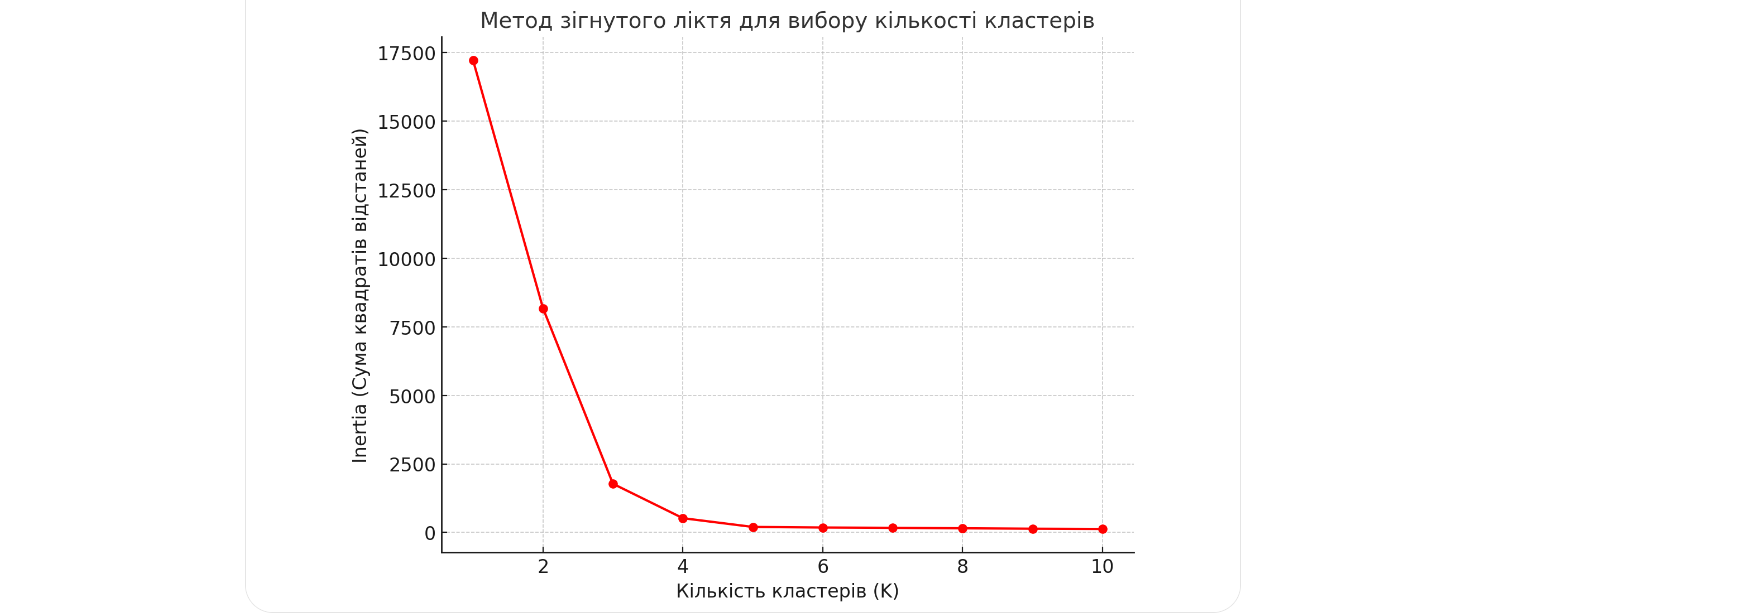
Ця точка згину і є оптимальним значенням k, оскільки вона вказує на компроміс між зменшенням внутрішньокластерної дисперсії та складністю моделі (надмірна кількість кластерів може призвести до перенавчання або ускладнення інтерпретації). Тому метод ліктя допомагає знайти оптимальну кількість кластерів, при якій кластери є достатньо компактними, а модель залишається простою та зрозумілою.

C:\Users\38050\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\38050\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\38050\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\38050\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

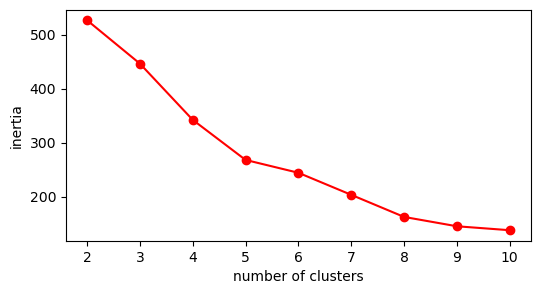

In [13]:
# реалізація методу зігнутого ліктя
from sklearn.cluster import KMeans
klusters = range(2, 11) # задамо кількість кластерів від 2 до 10 (верхня межа в функції range береться невключно)
inertias = []

for k in klusters:
    # задаємо метод кластеризації - к-середніх
    model = KMeans(n_clusters=k, random_state=42)
    #random_state дозволяє "закріпити" присвоєння кожній групі номеру кластеру при багаторазовому повторенні коду
    
    # оцінюємо модель
    model.fit(X_stand)
    
    # для кожної к-ті кластерів розраховуємо inertia, розраховані значення додаємо в список inertias
    inertias.append(model.inertia_)
    
# зобразимо на графіку показник inertia для кожної к-ті кластерів
plt.figure(figsize=(6,3))
plt.plot(klusters, inertias, '-o', color='red')
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.xticks(klusters)
plt.show()

Оптимальним можна вважати розбиття на 5 кластерів

### 3.2 Кластеризація та інтерпретація отриманих кластерів

In [16]:
# Розбиваємо дані на 5 кластерів
kmeans = KMeans(n_clusters=5, random_state=42) 
#random_state дозволяє "закріпити" присвоєння кожній групі номеру кластеру при багаторазовому повторенні коду

kmeans.fit(X_stand)

# Отримуємо відповідні кластери
labels = kmeans.predict(X_stand)
print(labels)

[4 2 4 2 4 2 0 2 0 4 0 2 4 2 0 4 0 2 0 2 4 2 0 4 4 2 0 2 4 2 0 2 4 2 4 2 4
 4 0 2 0 2 4 2 4 2 4 0 0 0 0 2 0 4 0 4 0 0 0 0 0 0 4 0 0 0 4 0 0 4 4 4 0 0
 0 0 0 0 0 0 0 0 0 0 4 0 4 0 4 4 4 0 4 0 4 0 0 0 4 4 0 4 0 4 0 0 0 4 4 0 0
 0 0 4 0 4 4 0 0 4 0 0 0 1 3 1 0 1 3 1 3 1 0 2 3 1 3 2 3 1 3 1 0 1 3 1 4 1
 3 1 3 1 3 1 3 1 3 1 3 1 4 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3
 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1]


C:\Users\38050\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [17]:
# додамо отримані значення кластерів до таблиці із початковими даними
data['Cluster'] = labels
data.head()

,Annual Income (k$),Spending Score (1-100),Discount Tier,Satisfaction Level,Cluster
0,15,39,1.0,3.0,4
1,15,81,2.0,3.0,2
2,16,6,0.0,3.0,4
3,16,77,2.0,2.0,2
4,17,40,1.0,4.0,4


In [18]:
#перевіримо наповненість кластерів
data[['Cluster']].value_counts()

Cluster
0          65
4          43
1          37
3          33
2          22
Name: count, dtype: int64

### Центри кластерів  
Після розбиття об'єктів на кластери необхідно інтерпретувати та дати характеристику кожному кластеру. Це можна зробити на основі аналізу центрів кластерів.  
**.cluster_centers_**  - метод для розрахунку центів кластерів.  
Центр кластера – найбільш типовий представник кластера (його геометричний центр). За характеристиками центру кластера можна судити про весь кластер.

In [20]:
centers = kmeans.cluster_centers_

In [21]:
# додамо отримані центри кластерів у датафрейм new_data
new_data = pd.DataFrame(centers, columns = [['Annual Income (k$)', 'Spending Score (1-100)', 'Discount Tier',
       'Satisfaction Level']])
new_data

,Annual Income (k$),Spending Score (1-100),Discount Tier,Satisfaction Level
0,-0.391325,-0.250250,-0.340938,-0.733462
1,1.020547,1.260756,1.283674,0.272773
2,-1.107469,1.075710,1.203580,-0.732488
3,1.078599,-1.327697,-1.274634,0.239093
4,-0.547758,-0.237985,-0.226763,1.065281


Так як попередня таблиця містить значення центрів кластерів у стандартизованому вигляді, то далі для кращої інтерпретації кластерів перейдемо до розрахунку середніх за кластерами значень у натуральних одиницях

In [23]:
# Середні за кластерами значення
mean_values = data.groupby('Cluster').mean()
print(mean_values)

         Annual Income (k$)  Spending Score (1-100)  Discount Tier  \
Cluster                                                              
0                 50.307692               43.753846       0.876923   
1                 87.297297               82.675676       2.297297   
2                 31.545455               77.909091       2.227273   
3                 88.818182               16.000000       0.060606   
4                 46.209302               44.069767       0.976744   

         Satisfaction Level  
Cluster                      
0                  0.907692  
1                  2.351351  
2                  0.909091  
3                  2.303030  
4                  3.488372  


**Нагадування**  
власний порядок для колонок, які необхідно перекодувати  
python  
```
custom_order = [
    ['No', 'Bronze', 'Silver', 'Gold'],  # Порядок для Discount Tier
    ['Very Dissatisfied', 'Dissatisfied', 'Neutral', 'Satisfied', 'Very Satisfied']  # Порядок для Satisfaction Level

На основі середніх значень для кожного кластеру в таблиці, яка включає показники доходу, витрат, рівня знижок та задоволеності, можна охарактеризувати кожен кластер таким чином:

**Кластер 0:**  
Річний дохід: $50.31k — середній дохід.  
Spending Score: 43.75 — помірний рівень витрат.  
Discount Tier: 0.88 — ближче до рівня "Bronze".  
Satisfaction Level: 0.91 — ближче до рівня "Dissatisfied".  
Інтерпретація: Цей кластер складається з клієнтів із середнім рівнем доходу, які витрачають на середньому рівні та отримують переважно мінімальні знижки ("Bronze"). Вони здебільшого незадоволені обслуговуванням.  

**Кластер 1:**    
Річний дохід: $87.30k — високий дохід.  
Spending Score: 82.68 — високий рівень витрат.  
Discount Tier: 2.30 — між рівнями "Silver" та "Gold" (ближче до "Silver").  
Satisfaction Level: 2.35 — між рівнями "Neutral" та "Satisfied".  
Інтерпретація: Клієнти з високим рівнем доходу, які витрачають значні суми, отримують помітні знижки. Загалом, вони більш-менш задоволені своїм досвідом покупок.  

**Кластер 2:**    
Річний дохід: $31.55k — низький дохід.  
Spending Score: 77.91 — високий рівень витрат.  
Discount Tier: 2.23 — між рівнями "Silver" та "Gold" (ближче до "Silver").  
Satisfaction Level: 0.91 — ближче до рівня "Dissatisfied".  
Інтерпретація: Клієнти з низьким доходом, які багато витрачають, отримують помітні знижки. Вони здебільшого незадоволені обслуговуванням.  

**Кластер 3:**  
Річний дохід: $88.82k — високий дохід.  
Spending Score: 16.00 — дуже низькі витрати.  
Discount Tier: 0.06 — майже не отримують знижок (ближче до "No").  
Satisfaction Level: 2.30 — між рівнями "Neutral" та "Satisfied" (ближче до "Neutral").  
Інтерпретація: Клієнти з високим доходом, але дуже обережні у витратах. Вони майже не отримують знижок, але здебільшого залишаються задоволеними покупками.  

**Кластер 4:**    
Річний дохід: $46.21k — середній дохід.  
Spending Score: 44.07 — середній рівень витрат.  
Discount Tier: 0.98 — переважно "Bronze" рівень знижок.  
Satisfaction Level: 3.49 — між рівнями "Satisfied" та "Very Satisfied" (ближче до "Very Satisfied").  
Інтерпретація: Клієнти із середнім рівнем доходу та витрат. Вони отримують невеликі знижки, але здебільшого дуже задоволені своїм досвідом.  

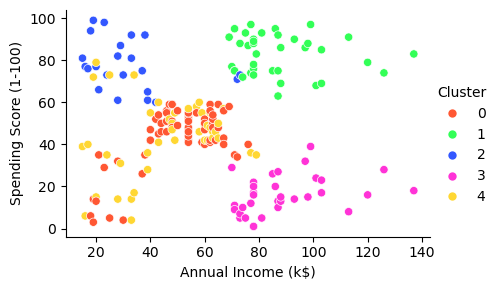

In [25]:
#Додатково: візуалізуємо розподіл доходів та витрат покупців за кластерами

# Вибір насиченої палітри з різними кольорами
palette = ['#FF5733', '#33FF57', '#3357FF', '#FF33D7', '#FFD733']  # Червоний, зелений, синій, рожевий, жовтий

# Побудова графіка з новою палітрою
sns.relplot(data=data, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette=palette, height=3, aspect=1.5)